In [39]:
import os
import json
import math
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

In [40]:
columns = ["Who", "Action", "Round", "AgentAUtility", "AgentBUtility","NashDistance"]

In [41]:
agents = ['MICROAgent','HybridAgent', 'BoulwareAgent', 'SAGAAgent', 'CUHKAgent',
          "ConcederAgent","NiceTitForTat", "IAMhaggler", "PonPokoAgent", "HardHeaded"]

In [42]:
# =============================================================================
# COLOR SCHEME CONFIGURATION - Wong's Colorblind-Safe Palette
# =============================================================================
# Reference: Wong, B. (2011). Points of view: Color blindness. Nature Methods 8, 441.
# This palette is widely used in Nature, Science, and other scientific journals.

WONG_COLORS = {
    'orange': '#E69F00',
    'sky_blue': '#56B4E9',
    'bluish_green': '#009E73',
    'yellow': '#F0E442',
    'blue': '#0072B2',
    'vermillion': '#D55E00',
    'reddish_purple': '#CC79A7',
    'black': '#000000'
}

# Map each agent to a specific color (10 base agents + Wong's 8 colors + 2 additional)
AGENT_COLORS = {
    'MICROAgent': WONG_COLORS['blue'],
    'HybridAgent': WONG_COLORS['orange'],
    'BoulwareAgent': WONG_COLORS['bluish_green'],
    'SAGAAgent': WONG_COLORS['vermillion'],
    'CUHKAgent': WONG_COLORS['reddish_purple'],
    'ConcederAgent': WONG_COLORS['sky_blue'],
    'NiceTitForTat': WONG_COLORS['yellow'],
    'IAMhaggler': '#8B4513',  # Saddle brown (additional color)
    'PonPokoAgent': '#2F4F4F',  # Dark slate gray (additional color)
    'HardHeaded': WONG_COLORS['black']
}

def get_agent_color(agent_name):
    """Get the assigned color for a given agent."""
    # Handle ParetoWalker variants
    if 'ParetoWalker' in agent_name:
        return '#800080'  # Purple for all ParetoWalker variants
    return AGENT_COLORS.get(agent_name, '#808080')  # Gray fallback

def get_agent_colors_list(agent_list):
    """Get list of colors for a list of agents."""
    return [get_agent_color(agent) for agent in agent_list]

# Helper Methods

In [43]:
def load_domain_disagreement_result(domain: str):
    spec_file = f"../../domains/domain{domain}/specs.json"
    with open(spec_file, "r") as f:
        spec = json.load(f)

    agent_A_reservation_value = spec["ReservationValueProfileA"]
    agent_B_reservation_value = spec["ReservationValueProfileB"]

    nash_bid = (spec["Nash_A"] , spec["Nash_B"]) 
    nash_distance = math.sqrt((nash_bid[0] - agent_A_reservation_value)**2 + (nash_bid[1] - agent_B_reservation_value)**2)
    return agent_A_reservation_value, agent_B_reservation_value, nash_distance

In [44]:
def process_session_sync(file_path, domain):
    try: 
        df = pd.read_excel(file_path,sheet_name="Session")
        df = df[columns]
        
        file_name = file_path.name
        agent_A = file_name.split("_")[0]
        agent_B = file_name.split("_")[1]
        
        acceptance_happened = False
        
        if df.iloc[-1]["Action"] == "Accept":
            acceptance_happened = True
            last_offer = df.iloc[-2].copy()
        else:
            last_offer = df.iloc[-1].copy()
            agent_A_utility, agent_B_utility, nash_distance = load_domain_disagreement_result(domain)
            last_offer.loc["AgentAUtility"] = agent_A_utility
            last_offer.loc["AgentBUtility"] = agent_B_utility
            last_offer.loc["NashDistance"] = nash_distance
        
        last_offer.loc["Action"] = "Accept" if acceptance_happened else "Failed"
        last_offer.loc["Agent_A"] = agent_A
        last_offer.loc["Agent_B"] = agent_B

        return last_offer
    
    except:
        return     

In [66]:
def load_tournament_results(base_dir, n_jobs=32):
    domains = {}
    
    for domain in os.listdir(base_dir):
        sessions_dir = Path(base_dir) / domain / "sessions"
        files = list(sessions_dir.iterdir())
        
        # Process files in parallel using joblib
        results = Parallel(n_jobs=n_jobs)(
            delayed(process_session_sync)(file, domain) 
            for file in tqdm(files, desc=f"Processing {domain}")
        )

        # Filter out None results
        results = [result for result in results if result is not None]
        
        df = pd.DataFrame(results)
        domains[domain] = df

    return domains

In [46]:
def aggregate_summary_statistics(df, agent_list=None):
    if agent_list is None:
        agent_list = agents  # Use global agents variable

    summary_df = pd.DataFrame()

    for agent in agent_list:
        # When this agent was Agent A
        agent_a_df = df[df["Agent_A"] == agent]
        summary_df.loc[agent, "AgentUtility_mean"] = agent_a_df["AgentAUtility"].mean()
        summary_df.loc[agent, "AgentUtility_std"] = agent_a_df["AgentAUtility"].std()
        summary_df.loc[agent, "AgentUtility_median"] = agent_a_df["AgentAUtility"].median()
        summary_df.loc[agent, "OpponentUtility_mean"] = agent_a_df["AgentBUtility"].mean()
        summary_df.loc[agent, "OpponentUtility_std"] = agent_a_df["AgentBUtility"].std()
        summary_df.loc[agent, "OpponentUtility_median"] = agent_a_df["AgentBUtility"].median()
        
        # When this agent was Agent B
        agent_b_df = df[df["Agent_B"] == agent]
        # Combine with Agent A stats
        all_agent_utility = pd.concat([agent_a_df["AgentAUtility"], agent_b_df["AgentBUtility"]])
        all_opponent_utility = pd.concat([agent_a_df["AgentBUtility"], agent_b_df["AgentAUtility"]])
        
        summary_df.loc[agent, "AgentUtility_mean"] = all_agent_utility.mean()
        summary_df.loc[agent, "AgentUtility_std"] = all_agent_utility.std()
        summary_df.loc[agent, "AgentUtility_median"] = all_agent_utility.median()
        summary_df.loc[agent, "OpponentUtility_mean"] = all_opponent_utility.mean()
        summary_df.loc[agent, "OpponentUtility_std"] = all_opponent_utility.std()
        summary_df.loc[agent, "OpponentUtility_median"] = all_opponent_utility.median()
        
        # For other numeric columns
        agent_df = df[(df["Agent_A"] == agent) | (df["Agent_B"] == agent)]
        for col in ["NashDistance", "Round"]:
            if col in df.columns:
                summary_df.loc[agent, f"{col}_mean"] = agent_df[col].mean()
                summary_df.loc[agent, f"{col}_std"] = agent_df[col].std()
                summary_df.loc[agent, f"{col}_median"] = agent_df[col].median()

        summary_df.loc[agent, "AcceptanceRate"] = len(agent_df[agent_df["Action"] == "Accept"]) / len(agent_df)
    return summary_df

In [47]:
def detect_opponent_model_from_filename(filename):
    """
    Extract opponent model name from ParetoWalker filename.
    Example: 'ParetoWalkerAgent_BoulwareAgent_Domain30_Oracle.xlsx' -> 'Oracle'
    
    Raises ValueError if filename doesn't match expected pattern.
    """
    if not filename.endswith('.xlsx'):
        raise ValueError(f"Expected .xlsx file, got: {filename}")
    
    # Remove extension and split by underscore
    name_without_ext = filename.replace('.xlsx', '')
    parts = name_without_ext.split('_')
    
    if len(parts) < 4:
        raise ValueError(f"Filename doesn't match expected pattern {filename}")
    
    # Last segment should be the opponent model
    opponent_model = parts[-1]
    return opponent_model

In [48]:
def map_opponent_model_to_display_name(opponent_model):
    """
    Map opponent model filename suffix to display name.
    Example: 'BayesianOpponentModel' -> 'Bayesian'
    
    Raises KeyError if opponent model not in mapping.
    """
    # Mapping following forecaster ablation pattern
    OPPONENT_MODEL_MAPPING = {
        'Oracle': 'Oracle',
        'BayesianOpponentModel': 'Bayesian',
        'ClassicFrequencyOpponentModel': 'ClassicFrequency',
        'CUHKOpponentModel': 'CUHK',
        'WindowedFrequencyOpponentModel': 'WindowedFrequency',
        'ConflictBasedOpponentModel': 'ConflictBased',
        'StepwiseCOMBOpponentModel': 'StepwiseCOMB',
        'ExpectationCOMBOpponentModel': 'ExpectationCOMB',
    }
    
    if opponent_model not in OPPONENT_MODEL_MAPPING:
        raise KeyError(f"Unknown opponent model: {opponent_model}")
    
    return OPPONENT_MODEL_MAPPING[opponent_model]

In [49]:
import re

def process_paretowalker_session_sync(file_path):
    """
    Process single ParetoWalker session file.
    Returns: Series with Agent_A, Agent_B, AgentAUtility, AgentBUtility, NashDistance, Action, Round, Domain
    """
    file_name = file_path.name
    
    # Parse filename: {AgentA}_{AgentB}_Domain{N}_{OpponentModel}.xlsx
    # Extract domain using regex
    domain_match = re.search(r'Domain(\d+)', file_name)
    if not domain_match:
        raise ValueError(f"Could not extract domain from filename: {file_name}")
    domain = domain_match.group(1)
    
    # Detect opponent model
    opponent_model_raw = detect_opponent_model_from_filename(file_name)
    opponent_model_display = map_opponent_model_to_display_name(opponent_model_raw)
    
    # Extract agent names: split filename and get first two parts
    name_parts = file_name.replace('.xlsx', '').split('_')
    agent_a_raw = name_parts[0]
    agent_b_raw = name_parts[1]
    
    # Transform agent names
    agent_a = f"ParetoWalker_{opponent_model_display}" if agent_a_raw == "ParetoWalkerAgent" else agent_a_raw
    agent_b = f"ParetoWalker_{opponent_model_display}" if agent_b_raw == "ParetoWalkerAgent" else agent_b_raw
    
    # Load Excel Session sheet
    df = pd.read_excel(file_path, sheet_name="Session")
    df = df[columns]
    
    # Determine outcome (same logic as process_session_sync)
    acceptance_happened = False
    
    if df.iloc[-1]["Action"] == "Accept":
        acceptance_happened = True
        last_offer = df.iloc[-2].copy()
    else:
        last_offer = df.iloc[-1].copy()
        agent_A_utility, agent_B_utility, nash_distance = load_domain_disagreement_result(domain)
        last_offer.loc["AgentAUtility"] = agent_A_utility
        last_offer.loc["AgentBUtility"] = agent_B_utility
        last_offer.loc["NashDistance"] = nash_distance
    
    last_offer.loc["Action"] = "Accept" if acceptance_happened else "Failed"
    last_offer.loc["Agent_A"] = agent_a
    last_offer.loc["Agent_B"] = agent_b
    
    return last_offer

In [50]:
def load_paretowalker_results(base_dir, n_jobs=32):
    """
    Load all ParetoWalker sessions from base directory.
    Returns: Dict mapping domain name -> DataFrame (same structure as load_tournament_results)
    """
    domains = {}
    
    # Walk directory tree to find all .xlsx files in sessions subdirectories
    all_files = []
    for root, dirs, files in os.walk(base_dir):
        if 'sessions' in root:
            for file in files:
                if file.endswith('.xlsx') and 'ParetoWalkerAgent' in file:
                    all_files.append(Path(root) / file)
    
    if not all_files:
        print(f"No ParetoWalker session files found in {base_dir}")
        return domains
    
    print(f"Found {len(all_files)} ParetoWalker session files")
    
    # Process files in parallel using joblib
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_paretowalker_session_sync)(file) 
        for file in tqdm(all_files, desc="Processing ParetoWalker sessions")
    )
    
    # Group results by domain (extract from filename)
    from collections import defaultdict
    domain_results = defaultdict(list)
    
    for file, result in zip(all_files, results):
        # Extract domain from filename
        domain_match = re.search(r'Domain(\d+)', file.name)
        if domain_match:
            domain_name = domain_match.group(1)
            domain_results[domain_name].append(result)
    
    # Create DataFrame for each domain
    for domain_name, results_list in domain_results.items():
        domains[domain_name] = pd.DataFrame(results_list)
    
    return domains

In [51]:
def build_expanded_agent_pool(base_agents, paretowalker_variants):
    """
    Build expanded agent list including ParetoWalker variants.
    
    Args:
        base_agents: List of base tournament agent names
        paretowalker_variants: List of opponent model variant names (e.g., ['Oracle', 'Bayesian'])
    
    Returns:
        Sorted list of all agents
    """
    expanded = list(base_agents)
    for variant in paretowalker_variants:
        expanded.append(f"ParetoWalker_{variant}")
    
    return sorted(expanded)

In [52]:
def merge_tournament_and_paretowalker(tournament_df, paretowalker_domains):
    """
    Merge tournament and ParetoWalker DataFrames.
    
    Args:
        tournament_df: DataFrame from tournament results
        paretowalker_domains: Dict mapping domain -> DataFrame from ParetoWalker
    
    Returns:
        Merged DataFrame with both tournament and ParetoWalker results
    """
    merged_df = tournament_df.copy()
    
    for domain, df in paretowalker_domains.items():
        merged_df = pd.concat([merged_df, df], ignore_index=True)
    
    return merged_df

# Visualizations

In [53]:
import matplotlib.pyplot as plt
import numpy as np

def plot_agent_opponent_utility_boxplot(overall_df):
    """
    Creates side-by-side box plots showing Agent Utility vs Opponent Utility for each agent.
    Similar to Figure 5 in the paper.
    
    Args:
        overall_df: DataFrame with columns Agent_A, Agent_B, AgentAUtility, AgentBUtility
        
    Returns:
        matplotlib figure object
    """
    # Prepare data for each agent
    data_to_plot = []
    box_colors = []
    edge_colors = []
    
    for agent in agents:
        # When this agent was Agent A
        agent_a_mask = overall_df["Agent_A"] == agent
        agent_a_utility = overall_df.loc[agent_a_mask, "AgentAUtility"]
        agent_a_opponent = overall_df.loc[agent_a_mask, "AgentBUtility"]
        
        # When this agent was Agent B
        agent_b_mask = overall_df["Agent_B"] == agent
        agent_b_utility = overall_df.loc[agent_b_mask, "AgentBUtility"]
        agent_b_opponent = overall_df.loc[agent_b_mask, "AgentAUtility"]
        
        # Combine both perspectives
        all_agent_utility = pd.concat([agent_a_utility, agent_b_utility])
        all_opponent_utility = pd.concat([agent_a_opponent, agent_b_opponent])
        
        data_to_plot.append(all_agent_utility.values)
        data_to_plot.append(all_opponent_utility.values)
        
        # Get agent color and use it for both boxes (different alpha for distinction)
        agent_color = get_agent_color(agent)
        box_colors.append(agent_color)  # Agent utility (darker)
        box_colors.append(agent_color)  # Opponent utility (lighter)
        edge_colors.append('black')
        edge_colors.append('black')
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Create box plots
    bp = ax.boxplot(data_to_plot, patch_artist=True, showmeans=True,
                    meanprops=dict(marker='x', markersize=8, markeredgewidth=2),
                    widths=0.6)
    
    # Color the boxes
    for i, (patch, color) in enumerate(zip(bp['boxes'], box_colors)):
        # Alternate alpha: agent utility (0.8), opponent utility (0.4)
        alpha = 0.8 if i % 2 == 0 else 0.4
        patch.set_facecolor(color)
        patch.set_alpha(alpha)
        patch.set_edgecolor('black')
        patch.set_linewidth(2)
    
    # Style whiskers, caps, and medians
    for whisker in bp['whiskers']:
        whisker.set_color('black')
        whisker.set_linewidth(2)
    for cap in bp['caps']:
        cap.set_color('black')
        cap.set_linewidth(2)
    for median in bp['medians']:
        median.set_color('black')
        median.set_linewidth(3)
    for mean in bp['means']:
        mean.set_markerfacecolor('black')
        mean.set_markeredgecolor('black')
    
    # Larger, bolder labels and title
    ax.set_ylabel('Utility', fontsize=22, fontweight='bold', labelpad=12)
    ax.set_title('Agent vs Opponent Utility by Agent', fontsize=26, fontweight='bold', pad=20)
    
    # Larger, bolder tick labels
    ax.set_xticks(np.arange(1, len(data_to_plot) + 1, 2))
    ax.set_xticklabels(agents, rotation=45, ha='right', fontsize=16, fontweight='bold')
    ax.tick_params(axis='y', labelsize=16)
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')
    
    ax.set_ylim(0, 1.0)
    ax.grid(axis='y', alpha=0.3, linewidth=1.5)
    
    # Legend with larger font
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='gray', alpha=0.8, edgecolor='black', label='Agent Utility'),
        Patch(facecolor='gray', alpha=0.4, edgecolor='black', label='Opponent Utility')
    ]
    ax.legend(handles=legend_elements, loc='lower left', fontsize=16, frameon=True, shadow=True)
    
    plt.tight_layout()
    plt.close()
    
    return fig

In [54]:
def plot_nash_distance_boxplot(overall_df):
    """
    Creates box plots showing Normalized Nash Distance for each agent.
    Similar to Figure 6 in the paper.
    
    Args:
        overall_df: DataFrame with columns Agent_A, Agent_B, NashDistance
        
    Returns:
        matplotlib figure object
    """
    # Prepare data for each agent and calculate median for sorting
    agent_data = []
    
    for agent in agents:
        # Get all games where this agent participated (as either A or B)
        agent_mask = (overall_df["Agent_A"] == agent) | (overall_df["Agent_B"] == agent)
        nash_distances = overall_df.loc[agent_mask, "NashDistance"]
        agent_data.append((agent, nash_distances.values, nash_distances.median()))
    
    # Sort by median Nash Distance (lowest to highest)
    agent_data.sort(key=lambda x: x[2])
    
    sorted_agents = [item[0] for item in agent_data]
    data_to_plot = [item[1] for item in agent_data]
    
    # Get colors for sorted agents
    agent_colors = [get_agent_color(agent) for agent in sorted_agents]
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Create box plots
    bp = ax.boxplot(data_to_plot, patch_artist=True, showmeans=True,
                    meanprops=dict(marker='x', markersize=8, markeredgewidth=2),
                    widths=0.6)
    
    # Color each box with agent-specific color
    for patch, color in zip(bp['boxes'], agent_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')
        patch.set_linewidth(2)
    
    # Style whiskers, caps, medians, and means
    for whisker in bp['whiskers']:
        whisker.set_color('black')
        whisker.set_linewidth(2)
    for cap in bp['caps']:
        cap.set_color('black')
        cap.set_linewidth(2)
    for median in bp['medians']:
        median.set_color('black')
        median.set_linewidth(3)
    for mean in bp['means']:
        mean.set_markerfacecolor('black')
        mean.set_markeredgecolor('black')
    
    # Larger, bolder labels and title
    ax.set_ylabel('Normalized Nash Distance', fontsize=22, fontweight='bold', labelpad=12)
    ax.set_title('Nash Distance by Agent (sorted by median)', fontsize=26, fontweight='bold', pad=20)
    
    # Larger, bolder tick labels
    ax.set_xticklabels(sorted_agents, rotation=45, ha='right', fontsize=16, fontweight='bold')
    ax.tick_params(axis='y', labelsize=16)
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')
    
    ax.set_ylim(0, 1.0)
    ax.grid(axis='y', alpha=0.3, linewidth=1.5)
    
    plt.tight_layout()
    plt.close()
    
    return fig

In [55]:
import seaborn as sns

def plot_agent_utility_heatmap(overall_df):
    """
    Creates a heatmap showing agent utility values for each agent-opponent pairing.
    Rows include all agents (base + ParetoWalker variants).
    Columns only include base agents (no ParetoWalker).
    Agents are sorted by median utility.
    
    Args:
        overall_df: DataFrame with columns Agent_A, Agent_B, AgentAUtility, AgentBUtility
        
    Returns:
        matplotlib figure object
    """
    # Define base agents (opponents on x-axis)
    base_agents = ['MICROAgent', 'HybridAgent', 'BoulwareAgent', 'SAGAAgent', 'CUHKAgent',
                   'ConcederAgent', 'NiceTitForTat', 'IAMhaggler', 'PonPokoAgent', 'HardHeaded']
    
    # All agents on y-axis (includes ParetoWalker variants if present)
    all_agents = agents
    
    # Create matrix to store mean utilities
    utility_matrix = np.zeros((len(all_agents), len(base_agents)))
    
    for i, agent in enumerate(all_agents):
        for j, opponent in enumerate(base_agents):
            # Get games where agent is A and opponent is B
            mask_a = (overall_df["Agent_A"] == agent) & (overall_df["Agent_B"] == opponent)
            utilities_as_a = overall_df.loc[mask_a, "AgentAUtility"]
            
            # Get games where agent is B and opponent is A
            mask_b = (overall_df["Agent_B"] == agent) & (overall_df["Agent_A"] == opponent)
            utilities_as_b = overall_df.loc[mask_b, "AgentBUtility"]
            
            # Combine and calculate mean
            all_utilities = pd.concat([utilities_as_a, utilities_as_b])
            if len(all_utilities) > 0:
                utility_matrix[i, j] = all_utilities.mean()
    
    # Calculate median utility for each agent (row median)
    median_utilities = np.median(utility_matrix, axis=1)
    
    # Sort agents by median utility (highest to lowest)
    sorted_indices = np.argsort(median_utilities)[::-1]
    sorted_agents = [all_agents[i] for i in sorted_indices]
    
    # Reorder matrix rows only (keep columns in original order)
    utility_matrix_sorted = utility_matrix[sorted_indices, :]
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Create heatmap with larger fonts
    sns.heatmap(utility_matrix_sorted, annot=True, fmt='.2f', cmap='rocket',
                xticklabels=base_agents, yticklabels=sorted_agents,
                ax=ax, cbar_kws={'label': 'Utility'},
                vmin=0, vmax=1.0,
                annot_kws={'fontsize': 11, 'weight': 'bold'},
                linewidths=0.5, linecolor='white')
    
    # Larger, bolder labels and title
    ax.set_xlabel('Opponent (Base Agents)', fontsize=20, fontweight='bold', labelpad=10)
    ax.set_ylabel('Agent', fontsize=20, fontweight='bold', labelpad=10)
    ax.set_title('Agent Utility Heatmap (sorted by median)', fontsize=24, fontweight='bold', pad=15)
    
    # Larger, bolder tick labels
    ax.tick_params(axis='x', rotation=45, labelsize=16)
    ax.tick_params(axis='y', rotation=0, labelsize=16)
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')
    
    plt.setp(ax.get_xticklabels(), ha='right')
    
    # Larger colorbar
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('Utility', fontsize=18, fontweight='bold')
    
    plt.tight_layout()
    plt.close()
    
    return fig

In [56]:
def plot_nash_distance_heatmap(overall_df):
    """
    Creates a heatmap showing Nash distance values for each agent-opponent pairing.
    Rows include all agents (base + ParetoWalker variants).
    Columns only include base agents (no ParetoWalker).
    Agents are sorted by median Nash distance.
    
    Args:
        overall_df: DataFrame with columns Agent_A, Agent_B, NashDistance
        
    Returns:
        matplotlib figure object
    """
    # Define base agents (opponents on x-axis)
    base_agents = ['MICROAgent', 'HybridAgent', 'BoulwareAgent', 'SAGAAgent', 'CUHKAgent',
                   'ConcederAgent', 'NiceTitForTat', 'IAMhaggler', 'PonPokoAgent', 'HardHeaded']
    
    # All agents on y-axis (includes ParetoWalker variants if present)
    all_agents = agents
    
    # Create matrix to store mean Nash distances
    nash_matrix = np.zeros((len(all_agents), len(base_agents)))
    
    for i, agent in enumerate(all_agents):
        for j, opponent in enumerate(base_agents):
            # Get games where agent is A and opponent is B
            mask_ab = (overall_df["Agent_A"] == agent) & (overall_df["Agent_B"] == opponent)
            nash_ab = overall_df.loc[mask_ab, "NashDistance"]
            
            # Get games where agent is B and opponent is A
            mask_ba = (overall_df["Agent_B"] == agent) & (overall_df["Agent_A"] == opponent)
            nash_ba = overall_df.loc[mask_ba, "NashDistance"]
            
            # Combine and calculate mean
            all_nash = pd.concat([nash_ab, nash_ba])
            if len(all_nash) > 0:
                nash_matrix[i, j] = all_nash.mean()
    
    # Calculate median Nash distance for each agent (row median)
    median_nash = np.median(nash_matrix, axis=1)
    
    # Sort agents by median Nash distance (lowest to highest)
    sorted_indices = np.argsort(median_nash)
    sorted_agents = [all_agents[i] for i in sorted_indices]
    
    # Reorder matrix rows only (keep columns in original order)
    nash_matrix_sorted = nash_matrix[sorted_indices, :]
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Create heatmap with reversed colormap (lower values = lighter, higher = darker)
    sns.heatmap(nash_matrix_sorted, annot=True, fmt='.2f', cmap='rocket_r',
                xticklabels=base_agents, yticklabels=sorted_agents,
                ax=ax, cbar_kws={'label': 'Nash Distance'},
                annot_kws={'fontsize': 11, 'weight': 'bold'},
                linewidths=0.5, linecolor='white')
    
    # Larger, bolder labels and title
    ax.set_xlabel('Opponent (Base Agents)', fontsize=20, fontweight='bold', labelpad=10)
    ax.set_ylabel('Agent', fontsize=20, fontweight='bold', labelpad=10)
    ax.set_title('Nash Distance Heatmap (sorted by median)', fontsize=24, fontweight='bold', pad=15)
    
    # Larger, bolder tick labels
    ax.tick_params(axis='x', rotation=45, labelsize=16)
    ax.tick_params(axis='y', rotation=0, labelsize=16)
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')
    
    plt.setp(ax.get_xticklabels(), ha='right')
    
    # Larger colorbar
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('Nash Distance', fontsize=18, fontweight='bold')
    
    plt.tight_layout()
    plt.close()
    
    return fig

In [81]:
def plot_agent_utility_histograms(overall_df, bins=20, figsize=(28, 24)):
    """
    Creates stacked histograms showing agent utility distribution per opponent.
    
    One histogram per agent, where each opponent is a different color in the stack.
    
    Args:
        overall_df: DataFrame with columns Agent_A, Agent_B, AgentAUtility, AgentBUtility
        bins: Number of bins or bin edges (default: 20)
        figsize: Figure size tuple
        
    Returns:
        matplotlib figure object
    """
    # Define base agents only (no ParetoWalker opponents in the stack)
    base_agents = ['MICROAgent', 'HybridAgent', 'BoulwareAgent', 'SAGAAgent', 'CUHKAgent',
                   'ConcederAgent', 'NiceTitForTat', 'IAMhaggler', 'PonPokoAgent', 'HardHeaded']
    
    # All agents to analyze (includes ParetoWalker variants if present)
    all_agents = agents
    
    # Calculate grid size for subplots
    n_agents = len(all_agents)
    n_cols = 3
    n_rows = int(np.ceil(n_agents / n_cols))
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    
    # Find global min/max for consistent binning across all agents
    all_utilities = []
    for agent in all_agents:
        # When this agent was Agent A
        agent_a_mask = overall_df["Agent_A"] == agent
        agent_a_utilities = overall_df.loc[agent_a_mask, "AgentAUtility"]
        
        # When this agent was Agent B
        agent_b_mask = overall_df["Agent_B"] == agent
        agent_b_utilities = overall_df.loc[agent_b_mask, "AgentBUtility"]
        
        all_utilities.extend(agent_a_utilities.values)
        all_utilities.extend(agent_b_utilities.values)
    
    if not all_utilities:
        print("No utility data to plot")
        return fig
    
    global_min = np.min(all_utilities)
    global_max = np.max(all_utilities)
    bin_edges = np.linspace(global_min, global_max, bins + 1)
    
    # Plot histogram for each agent
    for agent_idx, agent in enumerate(all_agents):
        ax = axes[agent_idx]
        
        # Collect utility data for each opponent (base agents only)
        opponent_data = []
        opponent_labels = []
        opponent_colors = []
        
        for opponent in base_agents:
            # Get utilities when agent played against this opponent
            # When agent was A and opponent was B
            mask_a = (overall_df["Agent_A"] == agent) & (overall_df["Agent_B"] == opponent)
            utilities_a = overall_df.loc[mask_a, "AgentAUtility"]
            
            # When agent was B and opponent was A
            mask_b = (overall_df["Agent_B"] == agent) & (overall_df["Agent_A"] == opponent)
            utilities_b = overall_df.loc[mask_b, "AgentBUtility"]
            
            # Combine
            all_agent_utilities = pd.concat([utilities_a, utilities_b])
            
            if len(all_agent_utilities) > 0:
                opponent_data.append(all_agent_utilities.values)
                opponent_labels.append(opponent)
                opponent_colors.append(get_agent_color(opponent))
        
        if opponent_data:
            # Create stacked histogram
            ax.hist(opponent_data, bins=bin_edges, stacked=True,
                   color=opponent_colors, label=opponent_labels,
                   alpha=0.85, edgecolor='black', linewidth=0.5)
            
            # Larger, bolder title and labels
            ax.set_title(agent, fontsize=22, fontweight='bold', pad=12)
            ax.set_xlabel('Utility', fontsize=18, fontweight='bold', labelpad=10)
            ax.set_ylabel('Count', fontsize=18, fontweight='bold', labelpad=10)
            
            # Larger, bolder tick labels
            ax.tick_params(axis='both', labelsize=14)
            for label in ax.get_xticklabels():
                label.set_fontweight('bold')
            for label in ax.get_yticklabels():
                label.set_fontweight('bold')
            
            # Grid
            ax.grid(True, alpha=0.3, linewidth=1.5, axis='y')
            
            # Legend only on first subplot
            if agent_idx == 0:
                ax.legend(title='Opponent', title_fontsize=14,
                         fontsize=11, loc='upper left',
                         frameon=True, shadow=True, framealpha=0.9,
                         ncol=2)
        else:
            ax.axis('off')
    
    # Hide extra subplots
    for idx in range(n_agents, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Agent Utility Distribution by Opponent (Stacked Histograms)',
                fontsize=28, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

In [58]:
def plot_acceptance_rate_bar(overall_df):
    """
    Creates a bar graph showing acceptance rate for each agent.
    
    Args:
        overall_df: DataFrame with columns Agent_A, Agent_B, Action
        
    Returns:
        matplotlib figure object
    """
    # Calculate acceptance rate for each agent
    acceptance_rates = []
    
    for agent in agents:
        # Get all games where this agent participated
        agent_mask = (overall_df["Agent_A"] == agent) | (overall_df["Agent_B"] == agent)
        agent_games = overall_df.loc[agent_mask]
        
        # Calculate acceptance rate
        total_games = len(agent_games)
        accepted_games = len(agent_games[agent_games["Action"] == "Accept"])
        acceptance_rate = accepted_games / total_games if total_games > 0 else 0
        
        acceptance_rates.append(acceptance_rate)
    
    # Get colors for each agent
    bar_colors = [get_agent_color(agent) for agent in agents]
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Create bar plot with agent-specific colors
    bars = ax.bar(agents, acceptance_rates, color=bar_colors, 
                  edgecolor='black', linewidth=2, alpha=0.8)
    
    # Larger, bolder labels and title
    ax.set_xlabel('Agent', fontsize=22, fontweight='bold', labelpad=12)
    ax.set_ylabel('Acceptance Rate', fontsize=22, fontweight='bold', labelpad=12)
    ax.set_title('Acceptance Rate by Agent', fontsize=26, fontweight='bold', pad=20)
    
    # Larger, bolder tick labels
    ax.tick_params(axis='x', rotation=45, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')
    
    plt.setp(ax.get_xticklabels(), ha='right')
    
    ax.set_ylim(0, 1.0)
    ax.grid(axis='y', alpha=0.3, linewidth=1.5)
    
    # Add value labels on top of bars with larger, bolder font
    for bar, rate in zip(bars, acceptance_rates):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{rate:.2f}',
                ha='center', va='bottom', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.close()
    
    return fig

In [59]:
def plot_acceptance_rounds_boxplot(acceptance_df):
    """
    Creates box plots showing the round number at which acceptance happened for each agent.
    
    Args:
        acceptance_df: DataFrame filtered to only accepted negotiations with columns Agent_A, Agent_B, Round
        
    Returns:
        matplotlib figure object
    """
    # Prepare data for each agent
    data_to_plot = []
    
    for agent in agents:
        # Get all accepted games where this agent participated (as either A or B)
        agent_mask = (acceptance_df["Agent_A"] == agent) | (acceptance_df["Agent_B"] == agent)
        rounds = acceptance_df.loc[agent_mask, "Round"]
        data_to_plot.append(rounds.values)
    
    # Get colors for each agent
    agent_colors = [get_agent_color(agent) for agent in agents]
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Create box plots
    bp = ax.boxplot(data_to_plot, patch_artist=True, showmeans=True,
                    meanprops=dict(marker='x', markersize=8, markeredgewidth=2),
                    widths=0.6)
    
    # Color each box with agent-specific color
    for patch, color in zip(bp['boxes'], agent_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')
        patch.set_linewidth(2)
    
    # Style whiskers, caps, medians, and means
    for whisker in bp['whiskers']:
        whisker.set_color('black')
        whisker.set_linewidth(2)
    for cap in bp['caps']:
        cap.set_color('black')
        cap.set_linewidth(2)
    for median in bp['medians']:
        median.set_color('black')
        median.set_linewidth(3)
    for mean in bp['means']:
        mean.set_markerfacecolor('black')
        mean.set_markeredgecolor('black')
    
    # Larger, bolder labels and title
    ax.set_ylabel('Acceptance Round', fontsize=22, fontweight='bold', labelpad=12)
    ax.set_title('Acceptance Round by Agent', fontsize=26, fontweight='bold', pad=20)
    
    # Larger, bolder tick labels
    ax.set_xticklabels(agents, rotation=45, ha='right', fontsize=16, fontweight='bold')
    ax.tick_params(axis='y', labelsize=16)
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')
    
    ax.grid(axis='y', alpha=0.3, linewidth=1.5)
    
    plt.tight_layout()
    plt.close()
    
    return fig

# Results

## 1000 Round Tournament

In [67]:
domains = load_tournament_results("/home/ubuntu/negoformer/Negolog-RL/results/oracle/1000")

Processing 10:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 11:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 12:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 13:   0%|          | 0/105 [00:00<?, ?it/s]

Processing 14:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 15:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 21:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 26:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 25:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 37:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 22:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 23:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 27:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 28:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 29:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 30:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 38:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 39:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 41:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 42:   0%|          | 0/78 [00:00<?, ?it/s]

Processing 43:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 44:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 45:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 46:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 5:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 50:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 51:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 52:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 53:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 54:   0%|          | 0/84 [00:00<?, ?it/s]

Processing 55:   0%|          | 0/70 [00:00<?, ?it/s]

Processing 56:   0%|          | 0/91 [00:00<?, ?it/s]

Processing 57:   0%|          | 0/85 [00:00<?, ?it/s]

Processing 58:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 59:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 6:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 60:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 61:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 7:   0%|          | 0/100 [00:00<?, ?it/s]

Processing 9:   0%|          | 0/100 [00:00<?, ?it/s]

In [95]:
# Load ParetoWalker results
# Update this path to point to your ParetoWalker sessions directory
paretowalker_base_dir = "/home/ubuntu/negoformer/Negolog-RL/forecaster_results/1000"

try:
    paretowalker_domains = load_paretowalker_results(paretowalker_base_dir)
    print(f"Loaded {len(paretowalker_domains)} domains with ParetoWalker data")
except Exception as e:
    print(f"Could not load ParetoWalker data: {e}")
    paretowalker_domains = {}  # Empty dict if no data available

Found 6720 ParetoWalker session files


Processing ParetoWalker sessions:   0%|          | 0/6720 [00:00<?, ?it/s]

Loaded 40 domains with ParetoWalker data


In [96]:
import glob
available_domains = glob.glob("../../domains/domain*/specs.json")
print(f"Found {len(available_domains)} domain specs:")

# Extract domain numbers safely (handle cases where regex doesn't match)
domain_nums = []
for d in available_domains:
    match = re.search(r'domain(\d+)', d)
    if match:
        domain_nums.append(int(match.group(1)))

domain_nums = sorted(domain_nums)
print(f"Domain numbers: {domain_nums}")

Found 66 domain specs:
Domain numbers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]


In [97]:
# Discover which opponent model variants are present
opponent_models_found = set()

if paretowalker_domains:
    for domain_df in paretowalker_domains.values():
        for agent in pd.concat([domain_df['Agent_A'], domain_df['Agent_B']]).unique():
            if agent.startswith('ParetoWalker_'):
                opponent_models_found.add(agent.replace('ParetoWalker_', ''))
    
    print(f"Found ParetoWalker variants: {sorted(opponent_models_found)}")
else:
    print("No ParetoWalker data found, continuing with tournament-only analysis")

Found ParetoWalker variants: ['Bayesian', 'CUHK', 'ClassicFrequency', 'ConflictBased', 'ExpectationCOMB', 'Oracle', 'StepwiseCOMB', 'WindowedFrequency']


In [98]:
overall_df = pd.DataFrame()

for domain in domains.keys():
    df = domains[domain].copy()
    df['Domain'] = domain
    
    if overall_df.empty:
        overall_df = df
    else:
        overall_df = pd.concat([overall_df, df], ignore_index=True)

In [99]:
# Merge tournament and ParetoWalker data
if paretowalker_domains:
    overall_df_original_count = len(overall_df)
    overall_df = merge_tournament_and_paretowalker(overall_df, paretowalker_domains)
    print(f"Total sessions after merge: {len(overall_df)} (added {len(overall_df) - overall_df_original_count} ParetoWalker sessions)")
else:
    print("Skipping merge - no ParetoWalker data available")

Total sessions after merge: 10610 (added 6720 ParetoWalker sessions)


In [100]:
# Update agent pool to include ParetoWalker variants
base_agents = ['MICROAgent', 'HybridAgent', 'BoulwareAgent', 'SAGAAgent', 'CUHKAgent',
               'ConcederAgent', 'NiceTitForTat', 'IAMhaggler', 'PonPokoAgent', 'HardHeaded']

if opponent_models_found:
    agents = build_expanded_agent_pool(base_agents, sorted(opponent_models_found))
    print(f"Expanded agent pool ({len(agents)} agents):")
    print(agents)
else:
    agents = base_agents
    print(f"Using base agent pool ({len(agents)} agents)")

Expanded agent pool (18 agents):
['BoulwareAgent', 'CUHKAgent', 'ConcederAgent', 'HardHeaded', 'HybridAgent', 'IAMhaggler', 'MICROAgent', 'NiceTitForTat', 'ParetoWalker_Bayesian', 'ParetoWalker_CUHK', 'ParetoWalker_ClassicFrequency', 'ParetoWalker_ConflictBased', 'ParetoWalker_ExpectationCOMB', 'ParetoWalker_Oracle', 'ParetoWalker_StepwiseCOMB', 'ParetoWalker_WindowedFrequency', 'PonPokoAgent', 'SAGAAgent']


In [101]:
aggregate_summary_statistics(overall_df).sort_values(by="NashDistance_mean", ascending=True)

,AgentUtility_mean,AgentUtility_std,AgentUtility_median,OpponentUtility_mean,OpponentUtility_std,OpponentUtility_median,NashDistance_mean,NashDistance_std,NashDistance_median,Round_mean,Round_std,Round_median,AcceptanceRate
NiceTitForTat,0.686402,0.114426,0.68100,0.848475,0.069942,0.85180,0.146165,0.100664,0.138735,557.267728,350.747571,580.5,1.000000
BoulwareAgent,0.705920,0.140312,0.72080,0.816518,0.127937,0.83200,0.146788,0.146553,0.115315,606.266141,185.843805,601.0,0.986370
HybridAgent,0.693842,0.185766,0.72920,0.770850,0.208624,0.81420,0.158483,0.243539,0.095910,599.301805,276.823473,625.0,0.939350
ParetoWalker_Bayesian,0.742161,0.191742,0.78310,0.734275,0.188018,0.76630,0.159735,0.233797,0.109743,676.791667,233.745816,669.5,0.948810
IAMhaggler,0.673145,0.155381,0.69940,0.812718,0.180104,0.85500,0.171995,0.196910,0.144222,505.215786,318.130809,533.0,0.964518
ParetoWalker_CUHK,0.735350,0.199821,0.78095,0.734799,0.197073,0.76660,0.173991,0.242319,0.114179,699.102381,220.050469,697.0,0.945238
ConcederAgent,0.659211,0.145450,0.66040,0.843450,0.133135,0.86600,0.189095,0.152239,0.175454,484.299928,212.627650,469.0,0.984859
ParetoWalker_ClassicFrequency,0.717576,0.232503,0.78270,0.710979,0.229162,0.75580,0.199018,0.281651,0.121244,713.182143,220.828306,726.0,0.919048
ParetoWalker_ConflictBased,0.721975,0.262187,0.79970,0.667854,0.247506,0.72800,0.212962,0.326565,0.102759,725.521429,229.125127,732.5,0.888095
ParetoWalker_Oracle,0.717358,0.276414,0.80800,0.652053,0.255907,0.72800,0.214814,0.351385,0.080620,754.657143,221.419683,816.5,0.871429


In [102]:
acceptance_df = overall_df[overall_df["Action"] == "Accept"]
aggregate_summary_statistics(acceptance_df).sort_values(by="NashDistance_mean", ascending=True)

,AgentUtility_mean,AgentUtility_std,AgentUtility_median,OpponentUtility_mean,OpponentUtility_std,OpponentUtility_median,NashDistance_mean,NashDistance_std,NashDistance_median,Round_mean,Round_std,Round_median,AcceptanceRate
ParetoWalker_Oracle,0.817713,0.070274,0.82205,0.743273,0.082295,0.74590,0.082611,0.070643,0.067282,718.606557,214.820482,729.0,1.0
HybridAgent,0.737304,0.067848,0.73400,0.819136,0.081670,0.82200,0.099153,0.070155,0.092453,573.495004,265.694227,603.0,1.0
ParetoWalker_ConflictBased,0.809348,0.079161,0.81400,0.748677,0.089971,0.74480,0.100315,0.078027,0.090510,691.061662,220.219315,683.5,1.0
ParetoWalker_Bayesian,0.780289,0.094180,0.79000,0.771997,0.089513,0.77320,0.108202,0.073998,0.103031,659.407779,227.327428,653.0,1.0
MICROAgent,0.851695,0.062949,0.85600,0.717948,0.111927,0.72800,0.111126,0.105195,0.091683,658.159145,296.605446,707.5,1.0
ParetoWalker_ClassicFrequency,0.779589,0.101642,0.79190,0.772422,0.097677,0.76830,0.118869,0.080709,0.111227,688.006477,212.665143,689.5,1.0
ParetoWalker_CUHK,0.775909,0.103082,0.78750,0.775327,0.097581,0.77510,0.119036,0.081731,0.111227,681.727960,213.802932,680.0,1.0
PonPokoAgent,0.849559,0.058134,0.84800,0.708553,0.112797,0.70600,0.126834,0.095366,0.117606,774.593688,227.662933,837.0,1.0
BoulwareAgent,0.715399,0.114744,0.72160,0.827481,0.086654,0.83360,0.134192,0.100522,0.113823,600.839273,181.254462,598.0,1.0
ParetoWalker_WindowedFrequency,0.816760,0.096632,0.83360,0.737917,0.117107,0.73810,0.134337,0.093350,0.127520,741.278970,212.269658,772.0,1.0


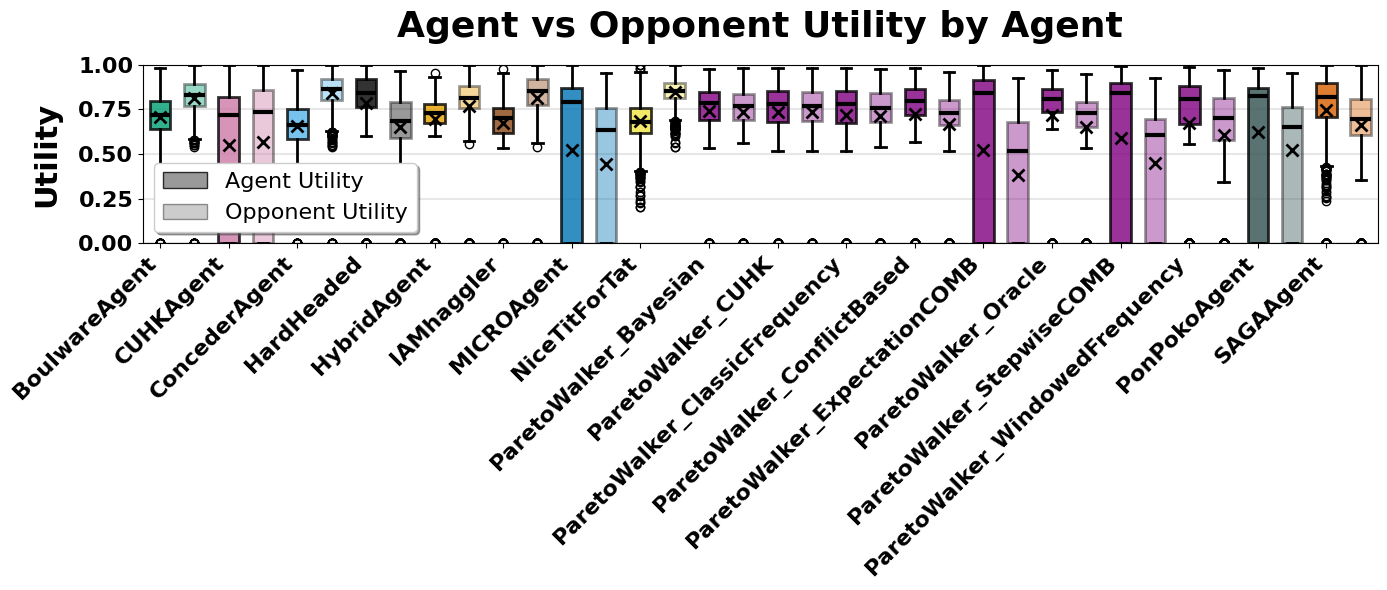

In [103]:
plot_agent_opponent_utility_boxplot(overall_df) 

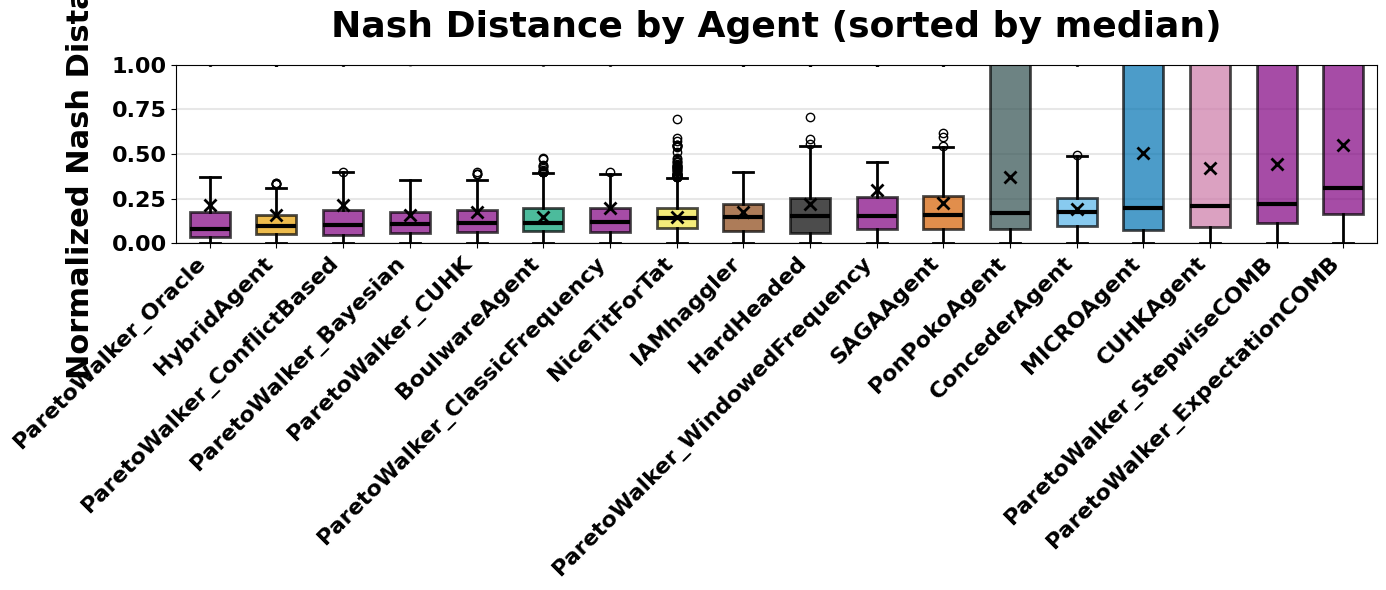

In [104]:
plot_nash_distance_boxplot(overall_df)

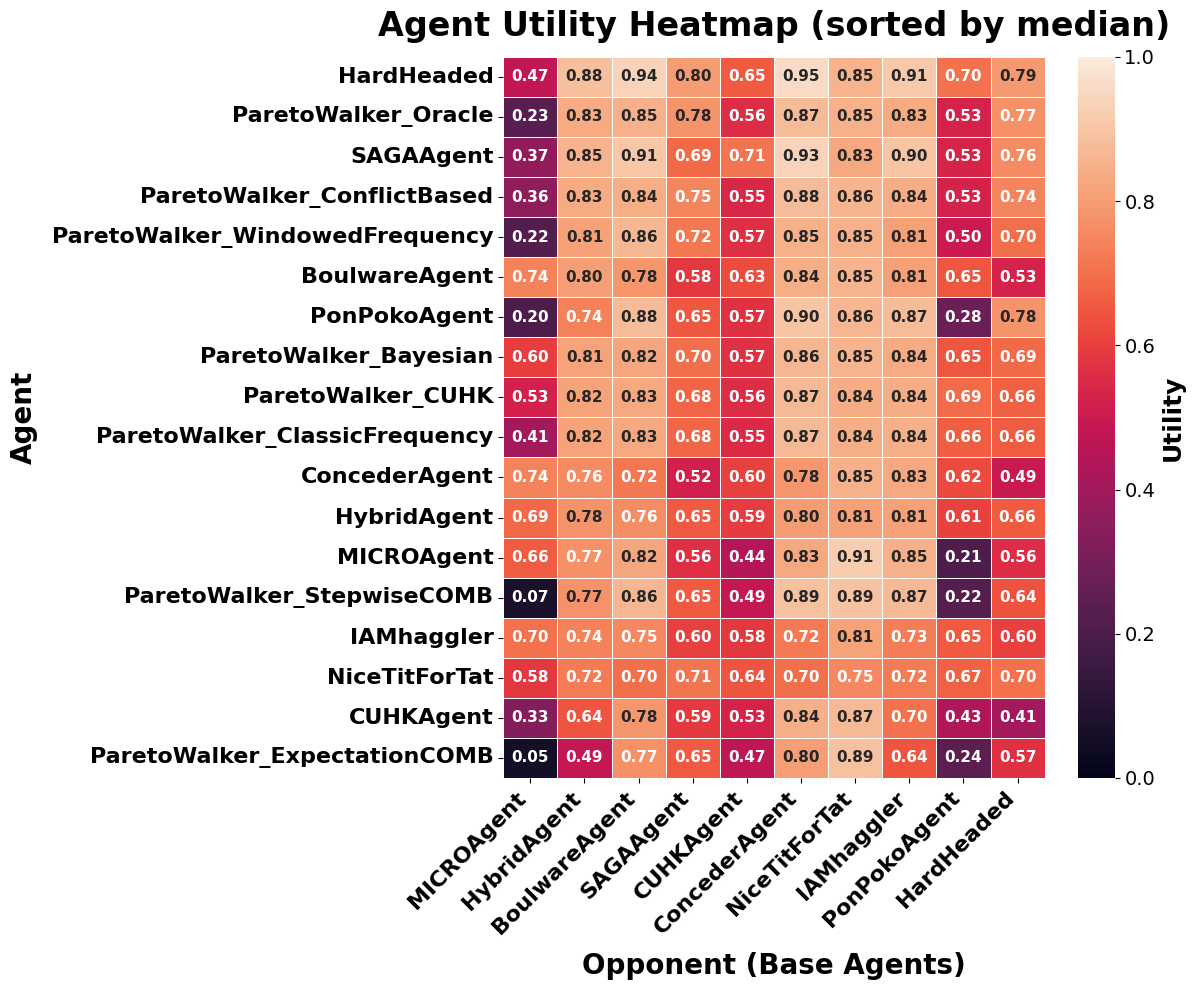

In [105]:
plot_agent_utility_heatmap(overall_df)

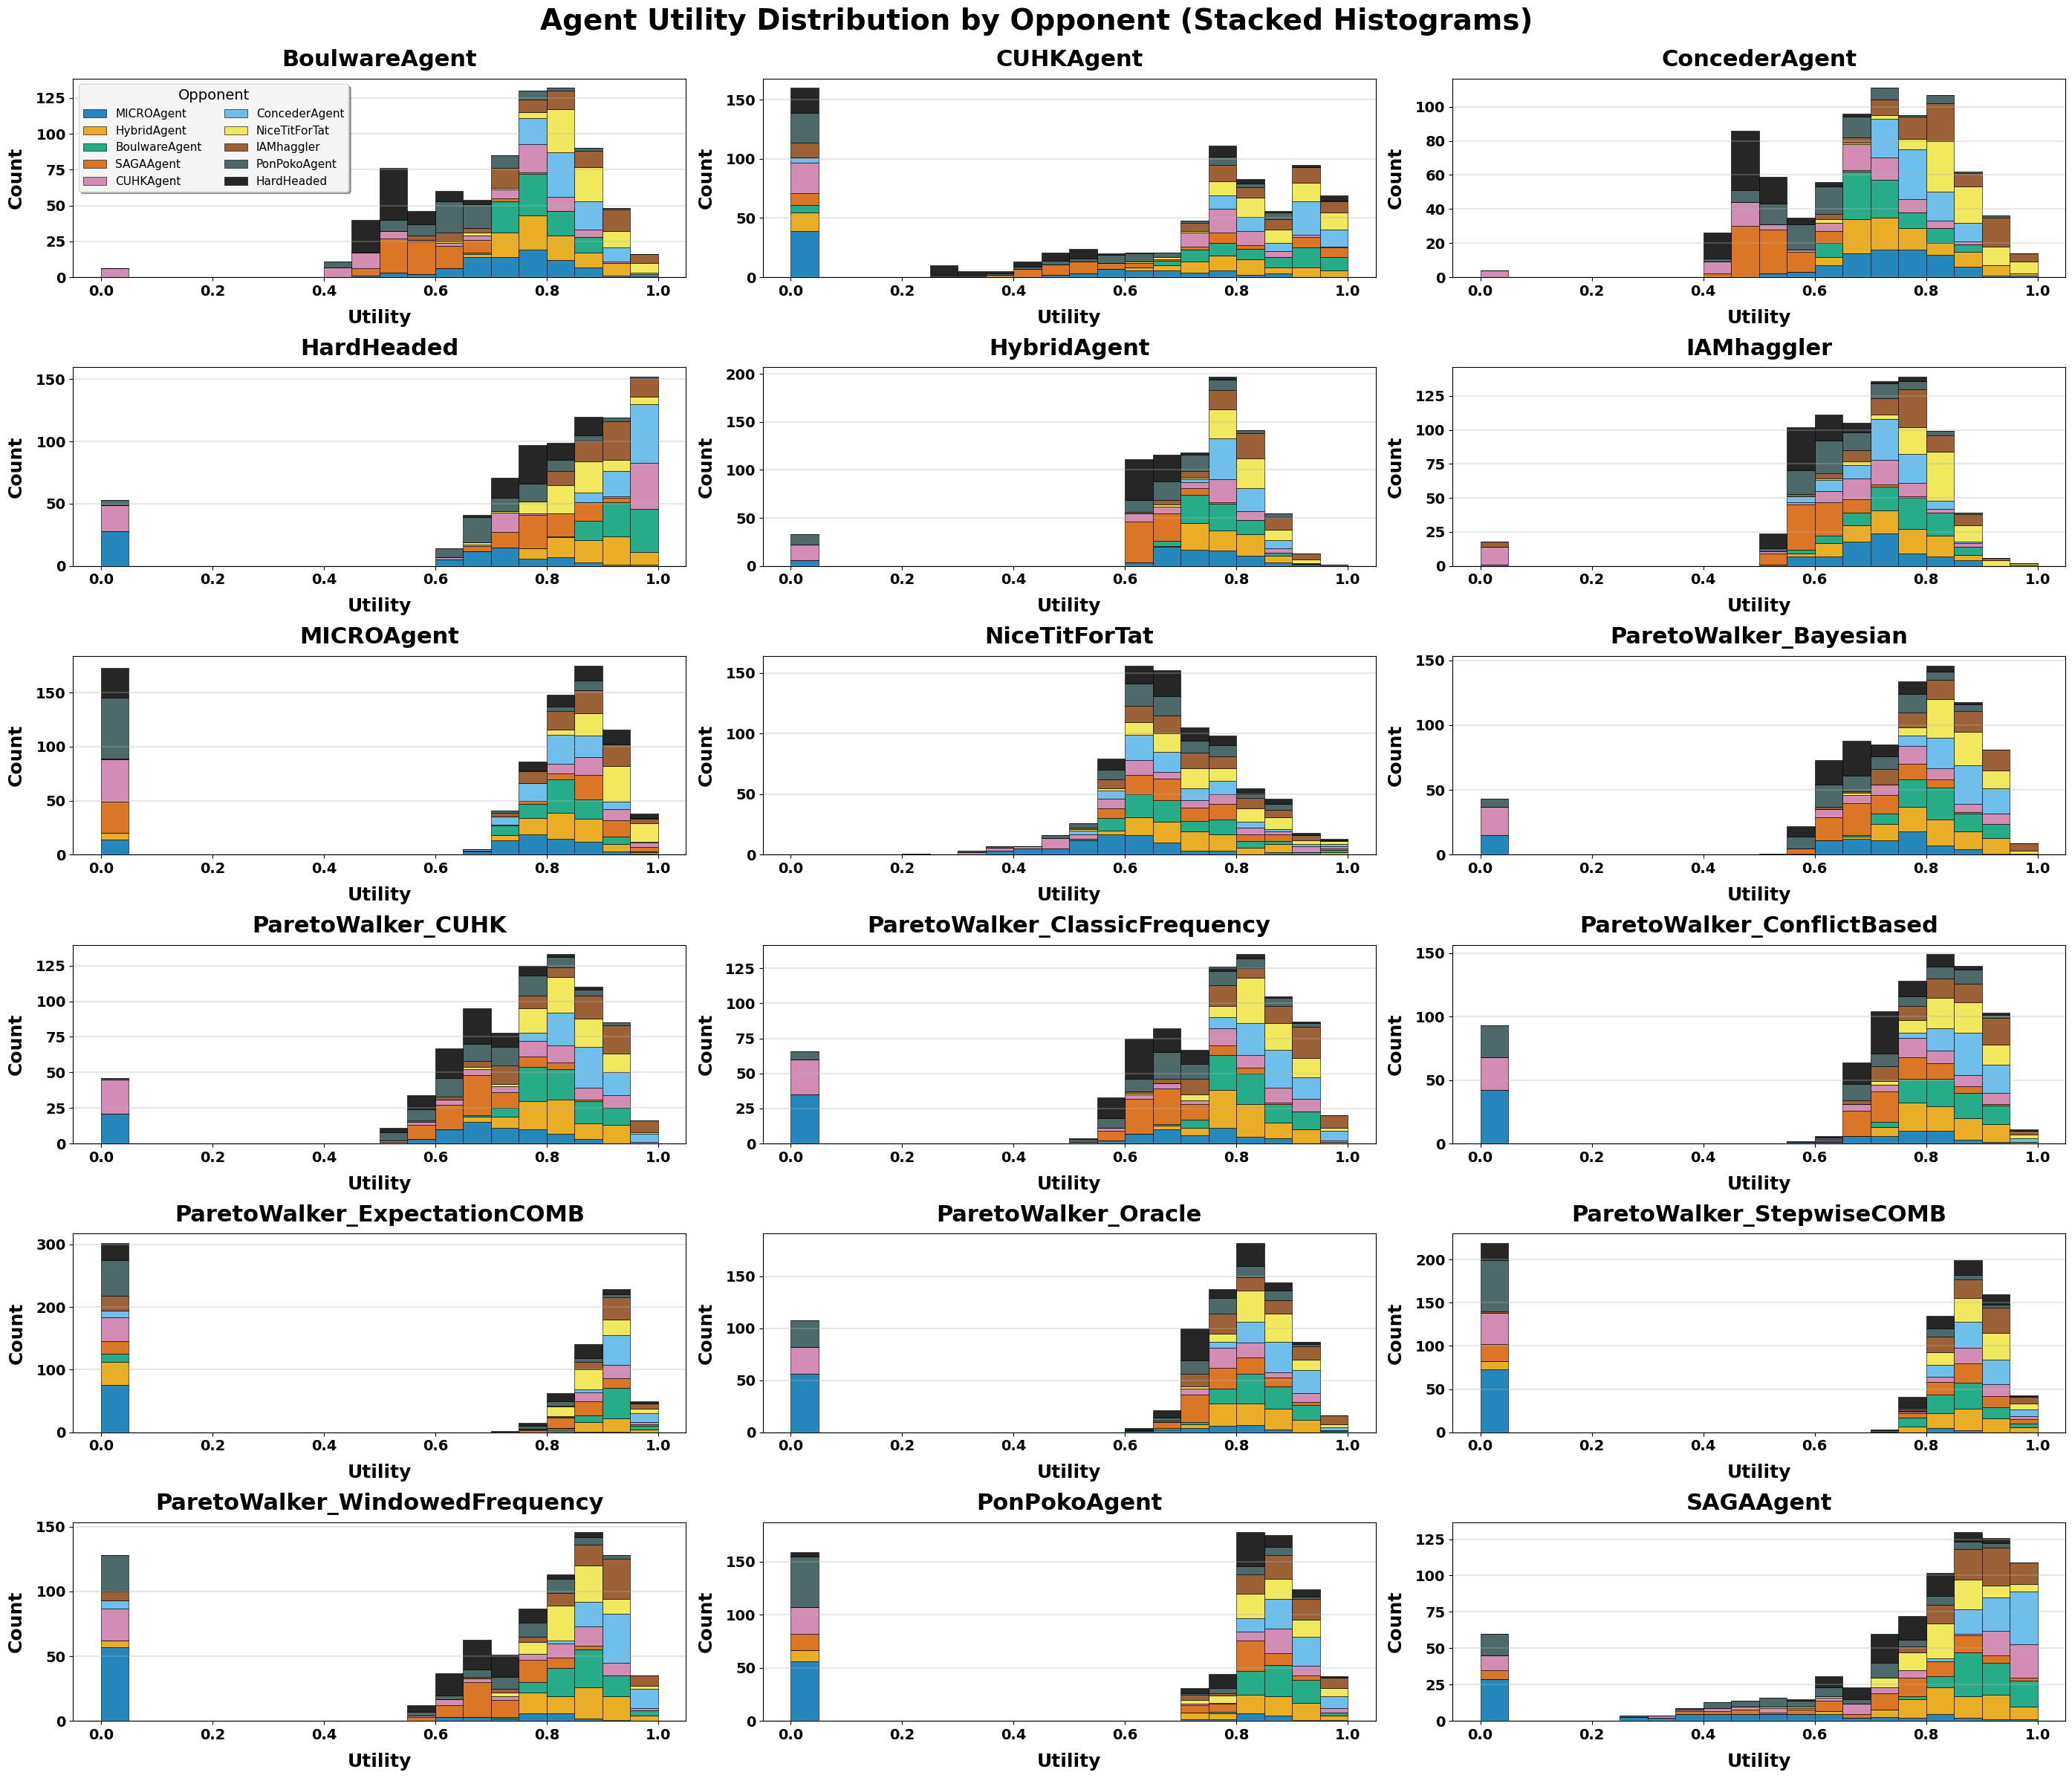

In [106]:
plot_agent_utility_histograms(overall_df)

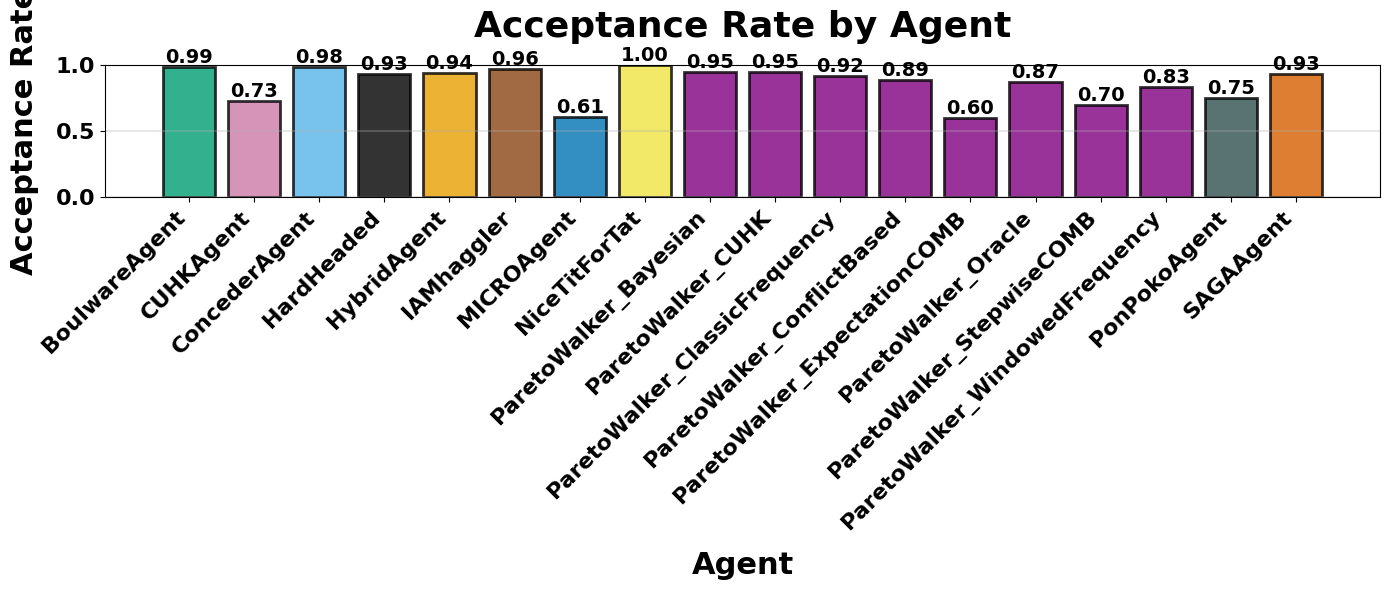

In [107]:
plot_acceptance_rate_bar(overall_df)

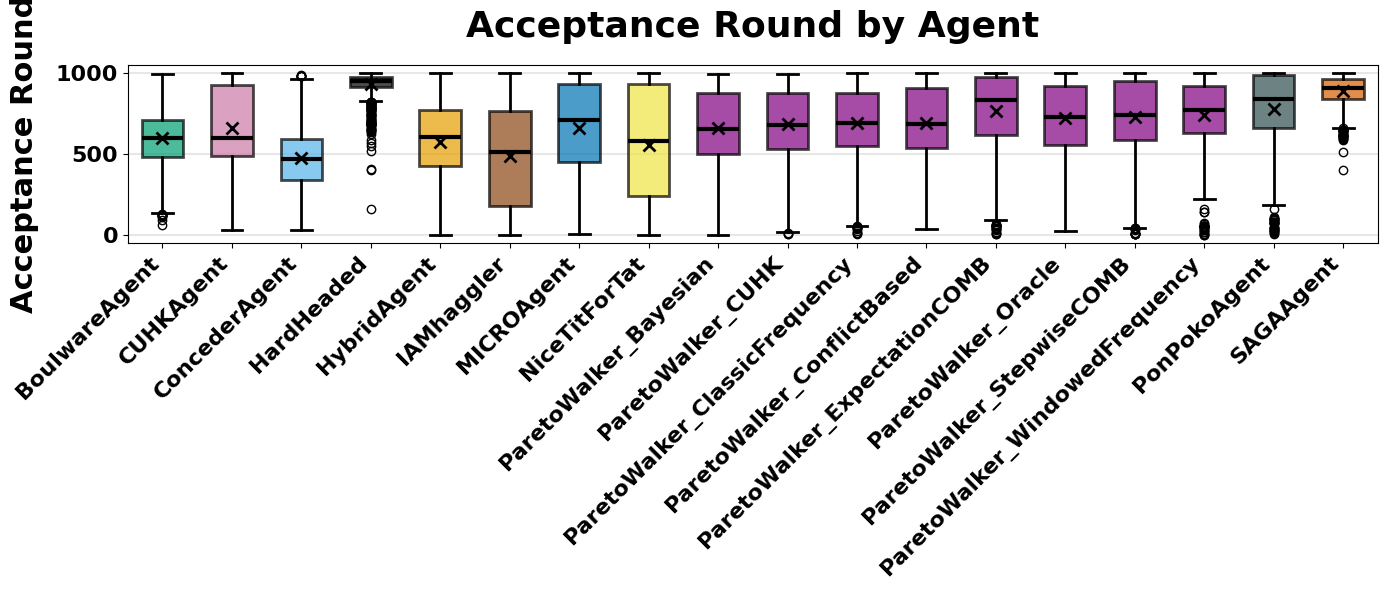

In [108]:
plot_acceptance_rounds_boxplot(acceptance_df)